In [4]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch

model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16).cuda().eval()

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  7.29it/s]


In [5]:
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct", trust_remote_code=True)

In [19]:
from pdf2image import convert_from_path
import time

start = time.time()
images = convert_from_path("/home/jovyan/danila_workflow/file_2.pdf", size=(1024, 1024))
print(time.time() - start)

0.7059252262115479


In [20]:
query = "What is the BLEU score for the transformer base model?"
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": images[7],
            },
            {"type": "text", "text": query},
        ],
    }
]

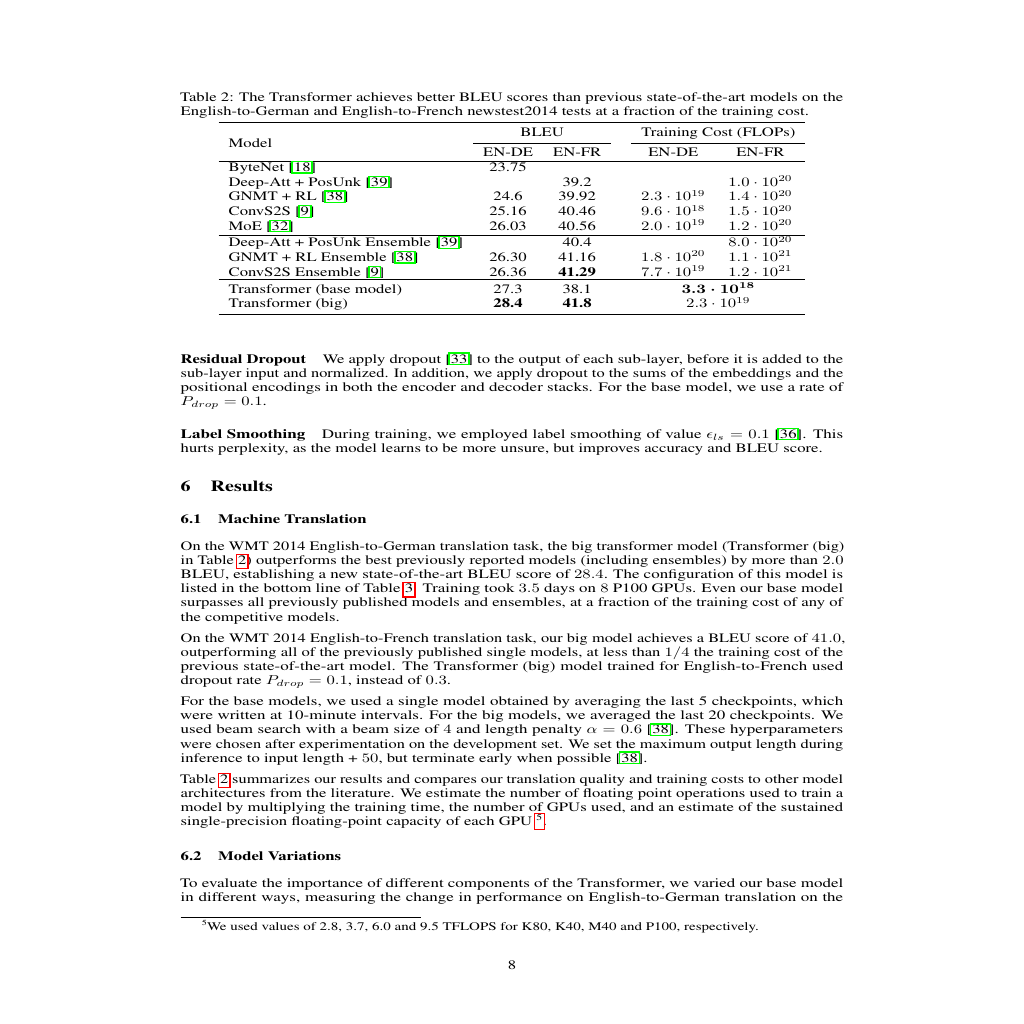

In [21]:
images[7]

In [22]:
start = time.time()
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt"
)
inputs = inputs.to("cuda")
with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=100)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    del generated_ids
    del inputs
    
    torch.cuda.empty_cache()
print(time.time() - start)

0.6215255260467529


In [23]:
output_text

['27.3']

In [11]:
!nvidia-smi

Sat Dec  7 16:02:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


|   0  NVIDIA H100 80GB HBM3          On  | 00000000:04:00.0 Off |                    0 |
| N/A   24C    P0             308W / 700W |  11653MiB / 81559MiB |     23%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   1  NVIDIA H100 80GB HBM3          On  | 00000000:23:00.0 Off |                    0 |
| N/A   21C    P0              72W / 700W |      3MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   2  NVIDIA H100 80GB HBM3          On  | 00000000:43:00.0 Off |                    0 |
| N/A   21C    P0              71W / 700W |      3MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+---------

In [24]:
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch
import time
from PIL import Image

class QwenAnswerGenerator:
    def __init__(self, model_name: str = "Qwen/Qwen2-VL-2B-Instruct", device: str = "cuda"):
        # Инициализация модели и процессора
        self.device = device
        self.model = self._load_model(model_name)
        self.processor = self._load_processor(model_name)

    def _load_model(self, model_name: str) -> Qwen2VLForConditionalGeneration:
        # Загрузка модели
        model = Qwen2VLForConditionalGeneration.from_pretrained(
            model_name,
            trust_remote_code=True,
            torch_dtype=torch.bfloat16
        ).to(self.device).eval()
        return model

    def _load_processor(self, model_name: str) -> AutoProcessor:
        # Загрузка процессора
        processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)
        return processor

    def generate_answer(self, image: Image, query: str) -> str:
        """
        Генерация ответа на основе изображения и текстового запроса.
        """
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": image},
                    {"type": "text", "text": query},
                ],
            }
        ]
        
        start = time.time()
        
        # Преобразование входных данных
        text = self.processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        image_inputs, video_inputs = process_vision_info(messages)
        inputs = self.processor(
            text=[text],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt"
        ).to(self.device)

        with torch.no_grad():
            # Генерация текста на основе модели
            generated_ids = self.model.generate(**inputs, max_new_tokens=100)
            generated_ids_trimmed = [
                out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
            ]
            output_text = self.processor.batch_decode(
                generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
            )
        
        # Очистка памяти GPU
        del generated_ids
        del inputs
        torch.cuda.empty_cache()

        print(f"Query processed in {time.time() - start:.2f} seconds.")
        return output_text[0]

In [25]:
from pdf2image import convert_from_path
from PIL import Image

# Создание экземпляра класса генератора ответов
answer_generator = QwenAnswerGenerator(model_name="Qwen/Qwen2-VL-2B-Instruct", device="cuda")

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]


In [26]:
# Преобразование PDF в изображения
images = convert_from_path("/home/jovyan/danila_workflow/file_2.pdf", size=(1024, 1024))

# Задание вопроса и выбор изображения
query = "What is the BLEU score for the transformer base model?"
image_to_query = images[7]  # Выбираем одно изображение для запроса

# Генерация ответа
answer = answer_generator.generate_answer(image_to_query, query)

print(f"Answer: {answer}")

Query processed in 0.74 seconds.
Answer: 27.3


In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import asyncio
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch
from PIL import Image
import time

class QwenAnswerGenerator:
    def __init__(self, model_name: str = "Qwen/Qwen2-VL-2B-Instruct", device: str = "cuda"):
        # Инициализация модели и процессора
        self.device = device
        self.model = self._load_model(model_name)
        self.processor = self._load_processor(model_name)

    def _load_model(self, model_name: str) -> Qwen2VLForConditionalGeneration:
        # Загрузка модели
        model = Qwen2VLForConditionalGeneration.from_pretrained(
            model_name,
            trust_remote_code=True,
            torch_dtype=torch.bfloat16
        ).to(self.device).eval()
        return model

    def _load_processor(self, model_name: str) -> AutoProcessor:
        # Загрузка процессора
        processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)
        return processor

    async def generate_answer(self, image: Image, query: str) -> str:
        """
        Асинхронная генерация ответа на основе изображения и текстового запроса.
        """
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": image},
                    {"type": "text", "text": query},
                ],
            }
        ]
        
        start = time.time()
        
        # Преобразование входных данных
        text = self.processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        image_inputs, video_inputs = process_vision_info(messages)
        inputs = self.processor(
            text=[text],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt"
        ).to(self.device)

        with torch.no_grad():
            # Генерация текста на основе модели
            generated_ids = self.model.generate(**inputs, max_new_tokens=100)
            generated_ids_trimmed = [
                out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
            ]
            output_text = self.processor.batch_decode(
                generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
            )
        
        # Очистка памяти GPU
        del generated_ids
        del inputs
        torch.cuda.empty_cache()

        print(f"Query processed in {time.time() - start:.2f} seconds.")
        return output_text[0]

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from pdf2image import convert_from_path
from PIL import Image

In [4]:
# Создание экземпляра генератора ответов
answer_generator = QwenAnswerGenerator(model_name="Qwen/Qwen2-VL-2B-Instruct", device="cuda")

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  7.27it/s]


In [7]:
# Преобразование PDF в изображения
images = convert_from_path("/home/jovyan/danila_workflow/file_2.pdf", size=(1024, 1024))
# Пример использования
async def main():
    # Преобразование PDF в изображения (предположим, что мы уже загружаем изображение)
    image = images[7]
    
    queries = [
        "Какова оценка BLEU для базовой модели transformer?",
        "Каково назначение механизмов внимания в transformers?",
        "Можете ли вы объяснить различия между моделями RNN и Transformer?"
    ]
    
    # Асинхронная обработка запросов
    tasks = []
    for query in queries:
        tasks.append(answer_generator.generate_answer(image, query))
    
    # Выполнение всех запросов одновременно
    answers = await asyncio.gather(*tasks)
    
    # Вывод ответов
    for answer in answers:
        print(answer)

await main()

Query processed in 1.67 seconds.
Query processed in 2.24 seconds.
Query processed in 1.27 seconds.
Оценка BLEU для базовой модели Transformer составляет 27.3.
Механизмы внимания в Transformerах играют ключевую роль в обучении модели на больших объемах данных. Они позволяют модели учитывать последовательность и взаимосвязи между словами, что позволяет модели лучше понимать и интерпретировать текст. В Transformerах используются различные виды внимания, такие как обратное внимание, обратное обратное внимание и обратное обратное обратное обратное обратное обратное
Для сравнения между моделями RNN и Transformer, мы использовали различные базовые модели и варианты, измеряя изменение в качестве на английском-немецком переводе.


In [8]:
!nvidia-smi

Sat Dec  7 16:22:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


|   0  NVIDIA H100 80GB HBM3          On  | 00000000:04:00.0 Off |                    0 |
| N/A   23C    P0             108W / 700W |   5255MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   1  NVIDIA H100 80GB HBM3          On  | 00000000:23:00.0 Off |                    0 |
| N/A   21C    P0              72W / 700W |      3MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   2  NVIDIA H100 80GB HBM3          On  | 00000000:43:00.0 Off |                    0 |
| N/A   21C    P0              71W / 700W |      3MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+---------